In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import math
import torch.nn.functional as F
import torchvision.transforms as transforms
import itertools
import random
from torch.nn.utils.rnn import pad_sequence
import wandb
import pandas as pd
import gc
from opacus import PrivacyEngine
from opacus.layers import DPLSTM
import time
from sklearn import metrics
import xgboost

In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nilm (use `wandb login --relogin` to force relogin)


True

In [3]:
torch.cuda.is_available()

True

In [4]:
gc.collect()
torch.cuda.empty_cache()

In [5]:
torch.__version__

'1.7.1'

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def get_home_ids(df):
    return df['dataid'].unique()

In [8]:
def load_all_houses_with_device(path, appliance):
        
    df = pd.read_csv(path, usecols = ['dataid', 'grid', 'solar', 'solar2', str(appliance)])
    
    size = len(df.dataid)
    dataids = get_home_ids(df)
    
    columns = {'dataid':df.dataid,
               'grid':df.grid,
               'solar':df.solar,
               'solar2':df.solar2,
                str(appliance):df[str(appliance)]}
    
    df = pd.DataFrame(columns)
    
    df['net_power'] = df.fillna(0).grid + df.fillna(0).solar + df.fillna(0).solar2
    df = df.fillna(0)
    df['net_power'] = np.clip(df['net_power']*1000, a_min = 0, a_max = None)
    df[str(appliance)] = np.clip(df[str(appliance)]*1000, a_min = 0, a_max = None)
    df['appliance_power'] = df[str(appliance)]
    df = df.drop(columns = ['grid', 'solar', 'solar2', str(appliance)])
    df['appliance_power'] = df['appliance_power'].values.astype('float32')
    df['net_power'] = df['net_power'].values.astype('float32')
    
    for house in dataids:
        house_of_interest = df.loc[df['dataid'] == house]
        if max(house_of_interest['appliance_power']) - min(house_of_interest['appliance_power']) < 60:
            df = df[df['dataid'] != house]
    
    return df

In [9]:
def normalize_x(x_sequence):
    std = np.std(x_sequence)
    x_sequence = (x_sequence - np.mean(x_sequence))/std    
    
    return x_sequence

In [10]:
def normalize_y(y_sequence):
    return (y_sequence - np.min(y_sequence))/(np.max(y_sequence) - np.min(y_sequence))

In [11]:
def create_activations(path, appliance, window_length, buildings):
    data = load_all_houses_with_device(path, appliance)
    
    data = [data.loc[data['dataid'] == i] for i in buildings]
        
    data = pd.concat(data)
    
    data_size = len(data)
    remainder = data_size % window_length
    
    y_data = data['appliance_power'].values
    x_data = data['net_power'].values
    
    if remainder != 0:
        y_data = np.append(y_data, np.zeros(window_length - remainder))
        x_data = np.append(x_data, np.zeros(window_length - remainder))
    
    y_data = np.reshape(y_data, (-1, window_length))
    x_data = np.reshape(x_data, (-1, window_length))
    
    data_size = len(y_data)
    
    y_data = y_data[0:data_size-1]
    x_data = x_data[0:data_size-1]
    
    for i in range(len(x_data)):
        x_data[i] = normalize_x(x_data[i])
    
    nan_tracker = []
    
    for i in range(len(y_data)):
        if max(y_data[i]) - min(y_data[i]) == 0:
            nan_tracker.append(i)
        elif max(y_data[i]) - min(y_data[i]) < 30:
            nan_tracker.append(i)
        
    y_data = [elem for i, elem in enumerate(y_data) if i not in nan_tracker]
    x_data = [elem for i, elem in enumerate(x_data) if i not in nan_tracker]
    
    for i in range(len(y_data)):
        y_data[i] = normalize_y(y_data[i])
    
    return np.array(x_data, dtype = np.float32), np.array(y_data, dtype = np.float32)

In [12]:
#column 2 is air1, NN is trained for air conditioner
#column 5 is washing machine
class PecanStreetDataset_train(Dataset):
    
    def __init__(self, path, appliance, window_length, buildings):
        
        self.x, self.y = create_activations(
            path,
            appliance,
            window_length,
            buildings)
        
        self.n_samples = self.x.shape[0]
                
        self.x = torch.from_numpy(self.x)
        
        self.y = torch.from_numpy(self.y)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [13]:
class PecanStreetDataset_test(Dataset):
    
    def __init__(self, path, appliance, window_length, buildings):
        
        self.x, self.y = create_activations(
            path,
            appliance,
            window_length,
            buildings)

        self.n_samples = self.x.shape[0]
        
        self.x = self.x[int(0.5*self.n_samples):]
        self.y = self.y[int(0.5*self.n_samples):]

        self.n_samples = self.x.shape[0]

        self.x = torch.from_numpy(self.x)
        
        self.y = torch.from_numpy(self.y)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [14]:
class PecanStreetDataset_val(Dataset):
    
    def __init__(self, path, appliance, window_length, buildings):

        self.x, self.y = create_activations(
            path,
            appliance,
            window_length,
            buildings)

        self.n_samples = self.x.shape[0]
        
        self.x = self.x[0:int(0.5*self.n_samples)]
        self.y = self.y[0:int(0.5*self.n_samples)]
        
        self.n_samples = self.x.shape[0]
        
        self.x = torch.from_numpy(self.x)
        
        self.y = torch.from_numpy(self.y)
        
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

In [15]:
class LSTM(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, hidden_size_1, hidden_size_2, fc1, fc2):
        super(LSTM, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=int((kernel_size-1)/2))
        #self.conv2 = nn.Conv1d(out_channels, out_channels_2, kernel_size, padding=int((kernel_size-1)/2))
        
        self.lstm1 = nn.LSTM(out_channels, hidden_size_1, num_layers = 2, batch_first = True, dropout = 0.5, bidirectional = True)
        self.lstm2 = nn.LSTM(2*hidden_size_1, hidden_size_2, num_layers = 2, batch_first = True, dropout = 0.5, bidirectional = True)
        
        self.linear1 = nn.Linear(2*hidden_size_2, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        self.linear3 = nn.Linear(fc2, in_channels)
        
        self.sigmoid = nn.Sigmoid()
        
        #self.maxpool = nn.MaxPool1d(kernel_size = kernel_size_2, stride = 1, padding = int((kernel_size_2-1)/2))
        
        #self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        #print("shape0: ", x.shape)
        out = x.unsqueeze(dim=1) #This unsqueeze is needed to create the correct shape for conv1 layer
        out = self.conv1(out)
        out = self.sigmoid(out)
        #out = self.maxpool(out)
        #print("shape2: ", out.shape)
        #out = self.relu(out)
        #out = self.sigmoid(out)
        #out = self.maxpool(out)
        #out = self.conv2(out)
        #out = self.relu(out)
        #out = self.dropout(out)
        #print("shape3: ", out.shape)
        #out, _ = self.lstm1(out)
        out = out.transpose(1, 2).contiguous()
        #print("shape3: ", out.shape)
        out, _ = self.lstm1(out)
        out, _ = self.lstm2(out)
        out = self.sigmoid(out)
        out = self.linear1(out)
        out = self.sigmoid(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        out = self.linear3(out)
        #print("shape4: ", out.shape)
        out = out.squeeze()
        #print("shape5: ", out.shape)
        return out

In [58]:
config = dict(
    epochs = 150,
    batch_size = 4,
    learning_rate = 0.0001,
    in_channels = 1,
    out_channels = 16,
    kernel_size = 7,
    hidden_size_1 = 32,
    hidden_size_2 = 100,
    fc1 = 128,
    fc2 = 64)

In [71]:
def model_pipeline(hyperparameters, train_months, test_month, path, appliance, window_length, train_buildings, test_buildings):
    
    with wandb.init(project = "Overfit_TrainBldg792_TestBldg5192_150epochs_4batch_1Conv_2BiLSTM_w_dropout", config = hyperparameters):
        wandb.run.name = "CyclicLR_base0.0001_max0.001_weightdecay0_kern:7_outchan:16_4sigmoid_0maxpool_"+str(window_length)
        config = wandb.config
        
        #ids = get_house_ids_of_interest(path, appliance)
        #ids = [792, 950, 1417, 3488, 3517, 4414, 6594]
        #ids = [792]
        
        #lengths = [85320, 132480, 132480, 132480, 132480, 132480, 132480]
        
        model, criterion, optimizer = make_model(config)
        
        print(model)
        
        wandb.watch(model, criterion, log = "all", log_freq = 10)
    
        example_ct = 0
        batch_ct = 0
        all_epochs = 0
        #all step_size=30 tests had gamma=0.5
        scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=.0001, max_lr=0.001, cycle_momentum=False, verbose=True)
            
        validation_loader, test_loader = make_test_val_data(config, test_month, appliance, window_length, test_buildings)
            
        #for i in range(len(ids)):
        time_log = time.time()
        train_loader = make_train_data(config, train_months, appliance, window_length, train_buildings)
        model, example_ct, batch_ct, all_epochs = train(
                model,
                train_loader,
                validation_loader,
                criterion,
                optimizer,
                config,
                example_ct,
                batch_ct,
                all_epochs,
                scheduler)
                
                #total_loss += per_house_total_loss
                #total_val_loss += per_house_val_loss
                #total_training_r2 += training_r2
                
        print("Time to train on one home: ", time.time() - time_log)
            
            #train_log(total_loss / len(ids), total_val_loss / len(ids), all_epochs, r)
            
        test(model, test_loader, criterion)
    
    return model

In [18]:
def make_train_data(config, train_data, appliance, window_length, train_buildings):
    
    root_path = r"C:\Users\aar245.CORNELL\Desktop\Fall2021_new\ithaca_Real_2019\1min_real_"

    train_dataset = PecanStreetDataset_train(str(root_path)+str(train_data)+"2019.csv", appliance, window_length, train_buildings)
    
    train_loader = DataLoader(dataset = train_dataset,
                                batch_size = config.batch_size,
                                shuffle = True,
                                num_workers = 0)
    
    return train_loader

In [19]:
def make_test_val_data(config, test_data, appliance, window_length, test_buildings):
    
    root_path = r"C:\Users\aar245.CORNELL\Desktop\Fall2021_new\ithaca_Real_2019\1min_real_"
    
    validation_dataset = PecanStreetDataset_val(str(root_path)+str(test_data)+"2019.csv", appliance, window_length, test_buildings)
    test_dataset = PecanStreetDataset_test(str(root_path)+str(test_data)+"2019.csv", appliance, window_length, test_buildings)
    
    validation_loader = DataLoader(dataset = validation_dataset,
                                  batch_size = config.batch_size,
                                  shuffle = False,
                                  num_workers = 0)
    
    test_loader = DataLoader(dataset = test_dataset,
                            batch_size = config.batch_size,
                            shuffle = False,
                            num_workers = 0)
    
    return validation_loader, test_loader

In [59]:
def make_model(config):
    
    model = LSTM(
        config.in_channels,
        config.out_channels,
        config.kernel_size,
        config.hidden_size_1,
        config.hidden_size_2,
        config.fc1,
        config.fc2).to(device)
    
    criterion = nn.MSELoss()
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config.learning_rate,
        weight_decay = 0)
    
    return model, criterion, optimizer

In [21]:
def train(model, loader, validation_loader, criterion, optimizer, config, example_ct, batch_ct, all_epochs, scheduler):#, privacy_engine):
    home_total_loss = 0.0
    total_validation_loss = 0.0
    #total_home_r2 = 0.0
    for epoch in (range(config.epochs)):
        model.train()
        epoch_total_loss = 0.0
        epoch_predictions = []
        epoch_true_vals = []
        epoch_r2 = 0.0
        batch_number = 0
        all_epochs += 1
        for _, (features, labels) in enumerate(loader):
            train_predictions, train_true_vals, loss = train_batch(features, labels, model, optimizer, criterion)
            epoch_total_loss += float(loss.item())
            epoch_predictions.append(train_predictions)
            epoch_true_vals.append(train_true_vals)
            example_ct += len(features)
            batch_ct += 1
            batch_number += 1
        
        scheduler.step()
        
        #validation process
        model.eval()
        with torch.no_grad():
            validation_total_loss = 0.0
            val_batch = 0
        
        for features, labels in validation_loader:
            features, labels = features.to(device), labels.to(device)

            outputs = model(features)
            loss = criterion(outputs, labels)

            validation_total_loss += float(loss.item())
            val_batch += 1
            del features, labels
        
        home_total_loss += epoch_total_loss / batch_number
        total_validation_loss += validation_total_loss / val_batch
        epoch_predictions = [item for sublist in epoch_predictions for item in sublist]
        epoch_true_vals = [item for sublist in epoch_true_vals for item in sublist]
        
        tracker = 0
        for i in range(len(epoch_predictions)):
            if len(epoch_true_vals[i]) != 1 and len(epoch_predictions[i]) != 1:
                for j in range(len(epoch_predictions[i])):
                    if len(epoch_true_vals[i][j].shape) != 0 and len(epoch_predictions[i][j].shape) != 0:
                        epoch_r2 += metrics.r2_score(epoch_true_vals[i][j], epoch_predictions[i][j])
                        tracker += 1
        
        wandb.log({
            'Per_House_Training_Loss': epoch_total_loss / batch_number,
            'Per_House_Validation_Loss': validation_total_loss / val_batch,
            'Per_House_Training_R2': epoch_r2 / tracker},
            step = example_ct)
        #'train_epsilon': train_epsilon,
        #'train_alpha': train_best_alpha},
        #step = example_ct)
        
        print(f"Loss after " + str(example_ct).zfill(5) + f" batches: {epoch_total_loss / batch_number:.4f}")

        #train_log(epoch_total_loss / batch_number,
        #        validation_total_loss / val_batch,
        #        example_ct,
        #        all_epochs)
        
    return model, example_ct, batch_ct, all_epochs

In [22]:
def train_batch(features, labels, model, optimizer, criterion):
    train_predictions = []
    train_true_vals = []
    
    features = features.to(device)
    labels = labels.to(device)
    
    outputs = model(features)
    loss = criterion(outputs, labels)
    
    train_predictions.append(outputs.cpu().detach().numpy())
    train_true_vals.append(labels.cpu().detach().numpy())
    
    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()
    del features, labels
    
    return train_predictions, train_true_vals, loss

In [23]:
def train_log(loss, val_loss, example_ct, epoch):
    loss = float(loss)
    val_loss = float(val_loss)
    
    wandb.log({
        "Rounds_on_all_homes": epoch,
        "All_Homes_Training_Loss": loss,
        "All_Homes_Validation_Loss": val_loss})
        #"All_Homes_Training_R2": training_r2})
              #step = example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" total epochs: {loss:.4f}")

In [24]:
def test(model, test_loader, criterion):#, privacy_engine):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        total_steps = 0
        r_squared = 0.0
        predictions = []
        true_vals = []
        for features, labels in test_loader:
            features, labels = features.to(device), labels.to(device)
            prediction = model(features)
            loss = criterion(prediction, labels)
            total_loss += float(loss.item())
            total_steps += 1
            #r_squared += float(metrics.r2_score(labels.cpu().detach().numpy(), prediction.cpu().detach().numpy()))
            predictions.append(prediction.cpu().detach().numpy())
            true_vals.append(labels.cpu().detach().numpy())
            del features, labels
        
        tracker = 0
        for i in range(len(predictions)):
            if len(true_vals[i]) != 1 and len(predictions[i]) != 1:
                for j in range(len(predictions[i])):
                    if len(true_vals[i][j].shape) != 0 and len(predictions[i][j].shape) != 0:
                        r_squared += metrics.r2_score(true_vals[i][j], predictions[i][j])
                        tracker += 1
        
        wandb.log({
            'Test_MSE': total_loss / total_steps,
            'Test_Mean_R2_Value': r_squared / tracker})
   # if privacy_engine:
        #epsilon, best_alpha = privacy_engine.get_privacy_spent()
        #print("Testing epsilon: ", epsilon)
        #print("Testing alpha: ", best_alpha)
    wandb.save("model_final.h5")

In [25]:
#get_house_ids_of_interest(path, 'air1')

In [26]:
path = r"C:\Users\aar245.CORNELL\Desktop\Fall2021_new\ithaca_Real_2019\1min_real_may_june_july2019.csv"

In [27]:
#test_lengths = [100, 200, 250, 300, 350, 400, 450, 500, 550, 600]
test_lengths = [15]

In [28]:
#batch_size = [2, 4, 10, 15, 20, 25, 30, 50]

In [104]:
random.seed(5)
for i in test_lengths:
    model_4 = model_pipeline(
    config,
    "may_june_july",
    'may_june_july',
    path,
    'air1',
    i,
    [5192],
    [792])
    #[792, 950, 1417, 3488, 3517, 4414, 6594],
    #[5192])

wandb: wandb version 0.12.4 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


LSTM(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(3,))
  (lstm1): LSTM(16, 32, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (lstm2): LSTM(64, 100, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear1): Linear(in_features=200, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Adjusting learning rate of group 0 to 1.0000e-04.


<ipython-input-9-b05ae6a46187>:3: RuntimeWarning: invalid value encountered in true_divide
  x_sequence = (x_sequence - np.mean(x_sequence))/std


Adjusting learning rate of group 0 to 1.0045e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 01523 batches: 0.1280
Adjusting learning rate of group 0 to 1.0090e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 03046 batches: 0.1210
Adjusting learning rate of group 0 to 1.0135e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 04569 batches: 0.1118
Adjusting learning rate of group 0 to 1.0180e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 06092 batches: 0.1093
Adjusting learning rate of group 0 to 1.0225e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 07615 batches: 0.1084
Adjusting learning rate of group 0 to 1.0270e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 09138 batches: 0.1064
Adjusting learning rate of group 0 to 1.0315e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 10661 batches: 0.1062
Adjusting learning rate of group 0 to 1.0360e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 12184 batches: 0.1055
Adjusting learning rate of group 0 to 1.0405e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 13707 batches: 0.1051
Adjusting learning rate of group 0 to 1.0450e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 15230 batches: 0.1044
Adjusting learning rate of group 0 to 1.0495e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 16753 batches: 0.1043
Adjusting learning rate of group 0 to 1.0540e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 18276 batches: 0.1042
Adjusting learning rate of group 0 to 1.0585e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 19799 batches: 0.1030
Adjusting learning rate of group 0 to 1.0630e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 21322 batches: 0.1029
Adjusting learning rate of group 0 to 1.0675e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 22845 batches: 0.1030
Adjusting learning rate of group 0 to 1.0720e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 24368 batches: 0.1030
Adjusting learning rate of group 0 to 1.0765e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 25891 batches: 0.1031
Adjusting learning rate of group 0 to 1.0810e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 27414 batches: 0.1018
Adjusting learning rate of group 0 to 1.0855e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 28937 batches: 0.1023
Adjusting learning rate of group 0 to 1.0900e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 30460 batches: 0.1013
Adjusting learning rate of group 0 to 1.0945e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 31983 batches: 0.1009
Adjusting learning rate of group 0 to 1.0990e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 33506 batches: 0.1002
Adjusting learning rate of group 0 to 1.1035e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 35029 batches: 0.1004
Adjusting learning rate of group 0 to 1.1080e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 36552 batches: 0.1009
Adjusting learning rate of group 0 to 1.1125e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 38075 batches: 0.1004
Adjusting learning rate of group 0 to 1.1170e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 39598 batches: 0.0998
Adjusting learning rate of group 0 to 1.1215e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 41121 batches: 0.1002
Adjusting learning rate of group 0 to 1.1260e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 42644 batches: 0.0991
Adjusting learning rate of group 0 to 1.1305e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 44167 batches: 0.0994
Adjusting learning rate of group 0 to 1.1350e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 45690 batches: 0.0987
Adjusting learning rate of group 0 to 1.1395e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 47213 batches: 0.1000
Adjusting learning rate of group 0 to 1.1440e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 48736 batches: 0.0996
Adjusting learning rate of group 0 to 1.1485e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 50259 batches: 0.0987
Adjusting learning rate of group 0 to 1.1530e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 51782 batches: 0.0987
Adjusting learning rate of group 0 to 1.1575e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 53305 batches: 0.0984
Adjusting learning rate of group 0 to 1.1620e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 54828 batches: 0.0991
Adjusting learning rate of group 0 to 1.1665e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 56351 batches: 0.0985
Adjusting learning rate of group 0 to 1.1710e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 57874 batches: 0.0971
Adjusting learning rate of group 0 to 1.1755e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 59397 batches: 0.0979
Adjusting learning rate of group 0 to 1.1800e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 60920 batches: 0.0974
Adjusting learning rate of group 0 to 1.1845e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 62443 batches: 0.0978
Adjusting learning rate of group 0 to 1.1890e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 63966 batches: 0.0974
Adjusting learning rate of group 0 to 1.1935e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 65489 batches: 0.0966
Adjusting learning rate of group 0 to 1.1980e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 67012 batches: 0.0973
Adjusting learning rate of group 0 to 1.2025e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 68535 batches: 0.0977
Adjusting learning rate of group 0 to 1.2070e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 70058 batches: 0.0985
Adjusting learning rate of group 0 to 1.2115e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 71581 batches: 0.0984
Adjusting learning rate of group 0 to 1.2160e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 73104 batches: 0.0973
Adjusting learning rate of group 0 to 1.2205e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 74627 batches: 0.0972
Adjusting learning rate of group 0 to 1.2250e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 76150 batches: 0.0966
Adjusting learning rate of group 0 to 1.2295e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 77673 batches: 0.0955
Adjusting learning rate of group 0 to 1.2340e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 79196 batches: 0.0956
Adjusting learning rate of group 0 to 1.2385e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 80719 batches: 0.0962
Adjusting learning rate of group 0 to 1.2430e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 82242 batches: 0.0968
Adjusting learning rate of group 0 to 1.2475e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 83765 batches: 0.0956
Adjusting learning rate of group 0 to 1.2520e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 85288 batches: 0.0961
Adjusting learning rate of group 0 to 1.2565e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 86811 batches: 0.0958
Adjusting learning rate of group 0 to 1.2610e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 88334 batches: 0.0967
Adjusting learning rate of group 0 to 1.2655e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 89857 batches: 0.0950
Adjusting learning rate of group 0 to 1.2700e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 91380 batches: 0.0946
Adjusting learning rate of group 0 to 1.2745e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 92903 batches: 0.0947
Adjusting learning rate of group 0 to 1.2790e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 94426 batches: 0.0957
Adjusting learning rate of group 0 to 1.2835e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 95949 batches: 0.0949
Adjusting learning rate of group 0 to 1.2880e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 97472 batches: 0.0948
Adjusting learning rate of group 0 to 1.2925e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 98995 batches: 0.0946
Adjusting learning rate of group 0 to 1.2970e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 100518 batches: 0.0946
Adjusting learning rate of group 0 to 1.3015e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 102041 batches: 0.0945
Adjusting learning rate of group 0 to 1.3060e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 103564 batches: 0.0939
Adjusting learning rate of group 0 to 1.3105e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 105087 batches: 0.0942
Adjusting learning rate of group 0 to 1.3150e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 106610 batches: 0.0947
Adjusting learning rate of group 0 to 1.3195e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 108133 batches: 0.0932
Adjusting learning rate of group 0 to 1.3240e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 109656 batches: 0.0938
Adjusting learning rate of group 0 to 1.3285e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 111179 batches: 0.0938
Adjusting learning rate of group 0 to 1.3330e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 112702 batches: 0.0935
Adjusting learning rate of group 0 to 1.3375e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 114225 batches: 0.0936
Adjusting learning rate of group 0 to 1.3420e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 115748 batches: 0.0957
Adjusting learning rate of group 0 to 1.3465e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 117271 batches: 0.0936
Adjusting learning rate of group 0 to 1.3510e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 118794 batches: 0.0930
Adjusting learning rate of group 0 to 1.3555e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 120317 batches: 0.0925
Adjusting learning rate of group 0 to 1.3600e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 121840 batches: 0.0936
Adjusting learning rate of group 0 to 1.3645e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 123363 batches: 0.0931
Adjusting learning rate of group 0 to 1.3690e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 124886 batches: 0.0927
Adjusting learning rate of group 0 to 1.3735e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 126409 batches: 0.0922
Adjusting learning rate of group 0 to 1.3780e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 127932 batches: 0.0935
Adjusting learning rate of group 0 to 1.3825e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 129455 batches: 0.0930
Adjusting learning rate of group 0 to 1.3870e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 130978 batches: 0.0924
Adjusting learning rate of group 0 to 1.3915e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 132501 batches: 0.0920
Adjusting learning rate of group 0 to 1.3960e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 134024 batches: 0.0916
Adjusting learning rate of group 0 to 1.4005e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 135547 batches: 0.0919
Adjusting learning rate of group 0 to 1.4050e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 137070 batches: 0.0921
Adjusting learning rate of group 0 to 1.4095e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 138593 batches: 0.0920
Adjusting learning rate of group 0 to 1.4140e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 140116 batches: 0.0918
Adjusting learning rate of group 0 to 1.4185e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 141639 batches: 0.0925
Adjusting learning rate of group 0 to 1.4230e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 143162 batches: 0.0917
Adjusting learning rate of group 0 to 1.4275e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 144685 batches: 0.0907
Adjusting learning rate of group 0 to 1.4320e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 146208 batches: 0.0918
Adjusting learning rate of group 0 to 1.4365e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 147731 batches: 0.0915
Adjusting learning rate of group 0 to 1.4410e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 149254 batches: 0.0910
Adjusting learning rate of group 0 to 1.4455e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 150777 batches: 0.0915
Adjusting learning rate of group 0 to 1.4500e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 152300 batches: 0.0909
Adjusting learning rate of group 0 to 1.4545e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 153823 batches: 0.0909
Adjusting learning rate of group 0 to 1.4590e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 155346 batches: 0.0911
Adjusting learning rate of group 0 to 1.4635e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 156869 batches: 0.0903
Adjusting learning rate of group 0 to 1.4680e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 158392 batches: 0.0894
Adjusting learning rate of group 0 to 1.4725e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 159915 batches: 0.0918
Adjusting learning rate of group 0 to 1.4770e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 161438 batches: 0.0894
Adjusting learning rate of group 0 to 1.4815e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 162961 batches: 0.0913
Adjusting learning rate of group 0 to 1.4860e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 164484 batches: 0.0902
Adjusting learning rate of group 0 to 1.4905e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 166007 batches: 0.0897
Adjusting learning rate of group 0 to 1.4950e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 167530 batches: 0.0901
Adjusting learning rate of group 0 to 1.4995e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 169053 batches: 0.0906
Adjusting learning rate of group 0 to 1.5040e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 170576 batches: 0.0898
Adjusting learning rate of group 0 to 1.5085e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 172099 batches: 0.0907
Adjusting learning rate of group 0 to 1.5130e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 173622 batches: 0.0898
Adjusting learning rate of group 0 to 1.5175e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 175145 batches: 0.0899
Adjusting learning rate of group 0 to 1.5220e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 176668 batches: 0.0891
Adjusting learning rate of group 0 to 1.5265e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 178191 batches: 0.0896
Adjusting learning rate of group 0 to 1.5310e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 179714 batches: 0.0891
Adjusting learning rate of group 0 to 1.5355e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 181237 batches: 0.0895
Adjusting learning rate of group 0 to 1.5400e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 182760 batches: 0.0885
Adjusting learning rate of group 0 to 1.5445e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 184283 batches: 0.0890
Adjusting learning rate of group 0 to 1.5490e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 185806 batches: 0.0902
Adjusting learning rate of group 0 to 1.5535e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 187329 batches: 0.0887
Adjusting learning rate of group 0 to 1.5580e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 188852 batches: 0.0889
Adjusting learning rate of group 0 to 1.5625e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 190375 batches: 0.0888
Adjusting learning rate of group 0 to 1.5670e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 191898 batches: 0.0888
Adjusting learning rate of group 0 to 1.5715e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 193421 batches: 0.0887
Adjusting learning rate of group 0 to 1.5760e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 194944 batches: 0.0883
Adjusting learning rate of group 0 to 1.5805e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 196467 batches: 0.0878
Adjusting learning rate of group 0 to 1.5850e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 197990 batches: 0.0888
Adjusting learning rate of group 0 to 1.5895e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 199513 batches: 0.0883
Adjusting learning rate of group 0 to 1.5940e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 201036 batches: 0.0882
Adjusting learning rate of group 0 to 1.5985e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 202559 batches: 0.0889
Adjusting learning rate of group 0 to 1.6030e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 204082 batches: 0.0885
Adjusting learning rate of group 0 to 1.6075e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 205605 batches: 0.0867
Adjusting learning rate of group 0 to 1.6120e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 207128 batches: 0.0881
Adjusting learning rate of group 0 to 1.6165e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 208651 batches: 0.0874
Adjusting learning rate of group 0 to 1.6210e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 210174 batches: 0.0882
Adjusting learning rate of group 0 to 1.6255e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 211697 batches: 0.0871
Adjusting learning rate of group 0 to 1.6300e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 213220 batches: 0.0879
Adjusting learning rate of group 0 to 1.6345e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 214743 batches: 0.0869
Adjusting learning rate of group 0 to 1.6390e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 216266 batches: 0.0872
Adjusting learning rate of group 0 to 1.6435e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 217789 batches: 0.0874
Adjusting learning rate of group 0 to 1.6480e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 219312 batches: 0.0864
Adjusting learning rate of group 0 to 1.6525e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 220835 batches: 0.0878
Adjusting learning rate of group 0 to 1.6570e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 222358 batches: 0.0872
Adjusting learning rate of group 0 to 1.6615e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 223881 batches: 0.0863
Adjusting learning rate of group 0 to 1.6660e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 225404 batches: 0.0870
Adjusting learning rate of group 0 to 1.6705e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 226927 batches: 0.0874
Adjusting learning rate of group 0 to 1.6750e-04.


C:\Users\aar245.CORNELL\Anaconda3\envs\mlenv\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([1, 15])) that is different to the input size (torch.Size([15])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss after 228450 batches: 0.0870
Time to train on one home:  5348.992865562439


Per_House_Training_Loss,0.08697
Per_House_Training_R2,-0.03697
Per_House_Validation_Loss,0.14362
Test_MSE,0.17608
Test_Mean_R2_Value,-0.275


Per_House_Training_Loss,█▆▅▅▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁
Per_House_Training_R2,▁▃▃▃▃▄▄▅▄▄▅▅▅▅▅▅▅▆▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████
Per_House_Validation_Loss,▇▇█▅▇▄▅▆▄▄▃▃▃▄▄▃▃▂▃▃▃▅▂▂▂▃▅▃▄▁▃▃▁▂▂▂▂▃▂▂
Test_MSE,▁
Test_Mean_R2_Value,▁


In [73]:
homes = load_all_houses_with_device(path, 'air1')

In [74]:
home1 = homes.loc[homes['dataid'] == 792]

In [75]:
home2 = homes.loc[homes['dataid'] == 5192]

In [76]:
std1 = np.std(home1['net_power'])

In [77]:
std2 = np.std(home2['net_power'])

In [78]:
x1 = (home1['net_power'] - np.mean(home1['net_power']))/std1

In [79]:
x2 = (home2['net_power'] - np.mean(home2['net_power']))/std2

Text(0, 0.5, 'Frequency')

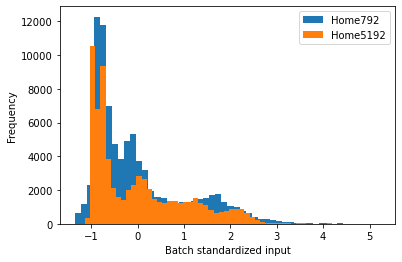

In [88]:
plt.hist(x1, bins = 50)
plt.hist(x2, bins = 50)
plt.legend(["Home792", "Home5192"])
plt.xlabel("Batch standardized input")
plt.ylabel("Frequency")

In [85]:
y1 = (home1['appliance_power'] - np.min(home1['appliance_power']))/(np.max(home1['appliance_power']) - np.min(home1['appliance_power']))

In [86]:
y2 = (home2['appliance_power'] - np.min(home2['appliance_power']))/(np.max(home2['appliance_power']) - np.min(home2['appliance_power']))

Text(0, 0.5, 'Frequency')

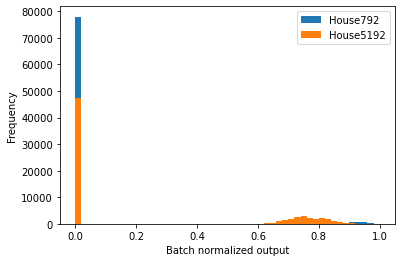

In [96]:
plt.hist(y1, bins = 50)
plt.hist(y2, bins = 50)
plt.legend(["House792", "House5192"])
plt.xlabel("Batch normalized output")
plt.ylabel("Frequency")

In [100]:
y1_on = [i for i in y1 if i > 0.02]

In [99]:
y2_on = [i for i in y2 if i > 0.02]

Text(0, 0.5, 'Frequency')

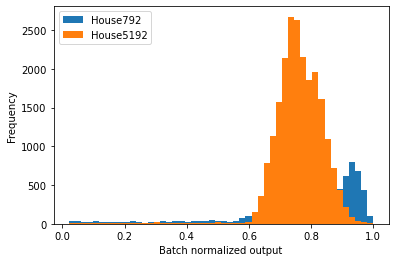

In [103]:
plt.hist(y1_on, bins = 50)
plt.hist(y2_on, bins = 50)
plt.legend(["House792", "House5192"])
plt.xlabel("Batch normalized output")
plt.ylabel("Frequency")

In [ ]:
def mean_relative_error_in_total_energy(true, predicted):
    #true = np.array(true)
    #predicted = np.array(predicted)
    abs_diff = abs(predicted - true)
    maximum = torch.maximum(abs(true), abs(predicted))
    return torch.mean(abs_diff/maximum)

In [ ]:
mean_relative_error_in_total_energy(torch.tensor(true_vals[0][2]), torch.tensor(predictions[0][2]))

In [ ]:
np.mean(abs(predictions[0][2] - true_vals[0][2]))/sum(true_vals[0][2])

In [ ]:
sum(true_vals[0][2])

In [ ]:
r2 = 0.0
for i in range(len(predictions[0])):
    r2 += metrics.r2_score(torch.tensor(true_vals[0][i]).cpu().detach().numpy(), torch.tensor(predictions[0][i]).cpu().detach().numpy())

In [ ]:
r2/len(predictions[0])

In [ ]:
metrics.r2_score(torch.tensor([0,1,2,3]), torch.tensor([2,3,4,5]))

In [ ]:
houses = separate_by_house(path, 'air1')

In [ ]:
len(houses[6594])

In [ ]:
test_inputs = []
predictions = []
true_vals = []

In [ ]:
model_4.cpu()

In [ ]:
total_r2_count = 0.0
for i, (inputs, outputs) in enumerate(test_loader):
    inputs, outputs = inputs.cpu(), outputs.cpu()
    prediction = model_4(inputs)
    
    predictions.append(prediction.detach().numpy())
    true_vals.append(outputs.detach().numpy())
    test_inputs.append(inputs)

In [ ]:
len(predictions)

In [ ]:
plt.plot(predictions[6][3])
plt.plot(true_vals[6][3])
plt.legend(['prediction', 'true'])
#plt.plot(test_inputs[0][2])

In [ ]:
flat_list = [i for subitems in predictions for i in subitems]

In [ ]:
flat_list = [i for subitems in flat_list for i in subitems]

In [ ]:
plt.plot(flat_list)

In [ ]:
flat_list_2 = [i for subitems in true_vals for i in subitems]

In [ ]:
flat_list_2 = [i for subitems in flat_list_2 for i in subitems]

In [ ]:
plt.scatter(flat_list_2, flat_list)
plt.plot(flat_list_2, flat_list_2)
plt.xlabel("Normalized True Values")
plt.ylabel("Normalized Predictions")
plt.title("Train:792,950,1417, Test:5192, window=15")

In [ ]:
flat_list_3 = [i for subitems in test_inputs for i in subitems]

In [ ]:
flat_list_3 = [i for subitems in flat_list_3 for i in subitems]

In [ ]:
plt.scatter(flat_list_2, flat_list_3)

In [ ]:
test_dataset = PecanStreetDataset_test(r"C:\Users\aar245.CORNELL\Desktop\Fall2021_new\ithaca_Real_2019\1min_real_may_june_july2019.csv", 'air1', 15, [5192])

In [ ]:
test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle = False, num_workers=0)

In [ ]:
test_dataset.x[0][10]

In [ ]:
predictions